In [1]:
import numpy as np
import pandas as pd
import re
import time
from termcolor import colored
import string
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten,Activation
from keras import optimizers
from keras.callbacks import EarlyStopping
import warnings
from gensim.models import Word2Vec, KeyedVectors

Using TensorFlow backend.


In [2]:
df_software = pd.read_json('data/Software_5.json', lines = True, encoding='utf-8')
df_science = pd.read_json('data/Industrial_and_Scientific_5.json', lines = True,encoding='utf-8')

In [3]:
df = pd.concat([df_software, df_science])

In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"10 20, 2010",A38NELQT98S4H8,0321719816,{'Format:': ' DVD-ROM'},WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800,NaN,NaN
1,4,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,{'Format:': ' DVD-ROM'},Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000,NaN,NaN
2,5,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,{'Format:': ' DVD-ROM'},D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200,3,NaN
3,5,False,"10 12, 2010",AYUF7YETYOLNX,0321719816,{'Format:': ' DVD-ROM'},Bryan Newman,I've been creating websites with Dreamweaver f...,A Fantastic Overview of Dream Weaver and Web D...,1286841600,NaN,NaN
4,5,False,"10 7, 2010",A31ICLWQ9CSHRS,0321719816,{'Format:': ' DVD-ROM'},Al Swanson,I decided (after trying a number of other prod...,Excellent Tutorials!,1286409600,NaN,NaN


In [5]:
df_text = df['reviewText'].values
df_score = df['overall'].values

In [6]:
text = []
score = []
c = 0 

for i in range(len(df_text)):
    if str(df_text[i]) != "nan":
        text.append(df_text[i])
        score.append(df_score[i])
    else:
        c += 1
#         print(i)

In [65]:
def cleanText(string):
    # print(colored('---------- NEW ----------', 'green', attrs=['bold']))
    # print(string)
    string = re.sub(r"[-()\"#/@;:<>{}+=./|.!?,~]", "", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    # print(colored('---------- CLEAN ----------', 'green', attrs=['bold']))
    # print(string.strip().lower())
    return string.strip().lower()

In [66]:
cleanT = []
for t in text:
    cleanT.append(cleanText(t))

In [9]:
stop_words =  ['if', 'do', '\'ve' , 'program' , 'window',  'windows', 'even' ,  'computer' ,'product' ,'\'ll' , 'use', 'used', 'one' ,'n\'t' , '\'re' , '\'s' ,'few', "it's", "shouldn't", 'myself', 'its', 'has', 'with', 'been', 'can', 'won', "you'll", 'below', "weren't", 'into', 'him', 'this', 'above', 'our', "needn't", 'here', 'i', 'me', 'all', 're', "won't", 'don', 'should', 'such', 'or', 'for', "couldn't", 'what', "should've", 'does', 'hers', 'other', "that'll", "doesn't", "wasn't", 'once', 'while', 'between', 'mightn', "hasn't", 'too', 'up', 'before', 'their', 'himself', 'it', "you'd", 'some', 'themselves', 'ain', 'an', 'ours', 'at', 'haven', 'about', 'just', 'shouldn', 'o', 'both', 'out', "isn't", 'll', 'ma', 'you', "haven't", 'only', 'hadn', 'those', 'they', 'against', 'down', 'over', 't', 'she', 'again', 'why', 'did', 'wouldn', 'a', 'when', 'your', 'ourselves', 'who', 'having', 'on', 'y', 'theirs', 'being', 'herself', 'nor', 'that', 'by', "don't", "mustn't", "shan't", 'because', 'not', 'under', 'are', 'he', 'own', "you've", 'there', 'yours', 'and', 'most', "mightn't", 'have', 'doing', 'during', 'couldn', "didn't", 'will', 'weren', 'd', 'were', "she's", "wouldn't", 'isn', 'then', 'doesn', 'wasn', 'itself', 'now', 'didn', 'these', 'them', 'needn', 'yourself', 'shan', 'is', 'more', 'be', "you're", 'than', 'after', 'aren', 'how', 'where', 'which', 'in', "hadn't", 'further', 'no', 'yourselves', 'as', 'whom', 'to', 'hasn', 'mustn', 'through', 'the', 'm', 's', 'very', 'we', 'each', 'until', 'same', "aren't", 'was', 'my', 'so', 'from', 've', 'am', 'had', 'his', 'but', 'off', 'any', 'of', 'her']
punctuation = list(string.punctuation)
stop = stop_words + punctuation

In [10]:
clean_text = []

for s in cleanT:
    sentence = s
    sent_words = sentence.split()
    words = [i for i in sent_words if i not in stop]
    output = ' '.join(words)
    clean_text.append(output)

In [11]:
positive_reviews = []
positive_score = []
negative_reviews = []
negative_score = []

for i in range(len(score)):
    if score[i] == 5:
        positive_reviews.append(clean_text[i])
        positive_score.append(score[i])
    elif score[i] == 1:
        negative_reviews.append(clean_text[i])
        negative_score.append(score[i])

In [12]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(str(data))
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color=color, width=2500, height=2000).generate(data)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [13]:
negative_words = ""

for i in range(len(negative_reviews)):
    negative_words += str(negative_reviews[i])

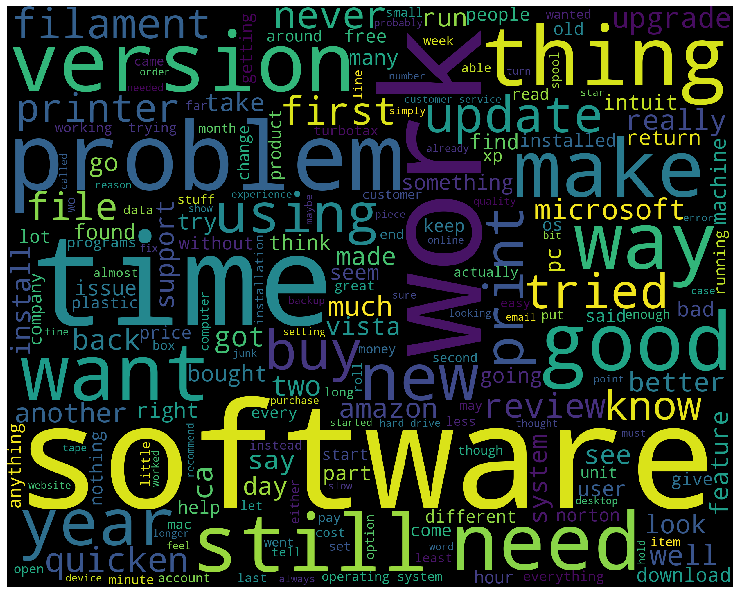

In [15]:
wordcloud_draw(negative_words)

In [14]:
positive_words = ""

for i in range(len(positive_reviews[0:1000])):
    positive_words += str(positive_reviews[i])

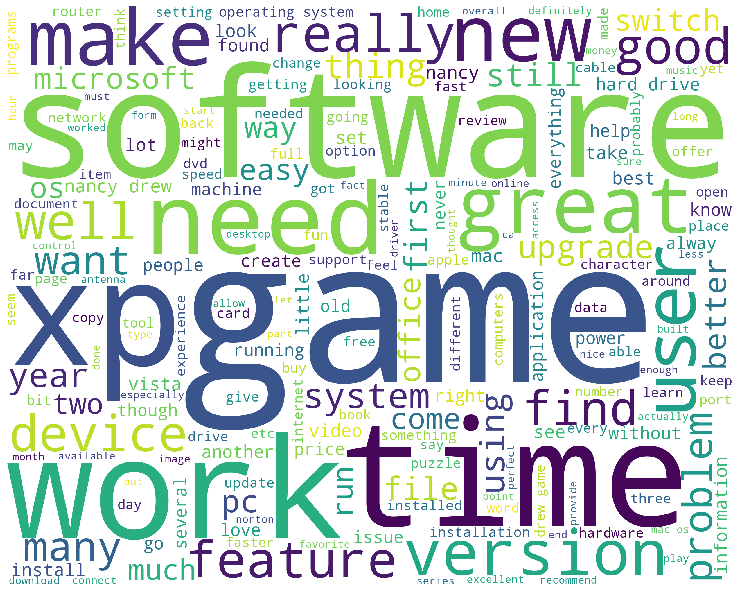

In [17]:
wordcloud_draw(positive_words, 'white')

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(clean_text, score, test_size = 0.3 , random_state = 0)

In [15]:
 corpus = []

for review in X_train:
    sent_words = review.split()
#     print(list(sent_words))
    corpus.append(list(sent_words))
# print(corpus)

In [16]:
model = Word2Vec(corpus,min_count=1,size=200)

In [17]:
model.wv.most_similar('hello')

[('fake', 0.9237756133079529),
 ('representatives', 0.9150944948196411),
 ('sally', 0.9116179347038269),
 ('soul', 0.9095038175582886),
 ('monku', 0.908510684967041),
 ('disclaimer', 0.9078487753868103),
 ('ebola', 0.9076909422874451),
 ('philosophy', 0.9071930050849915),
 ('inc', 0.9067771434783936),
 ('fyi', 0.9059888124465942)]

In [18]:
embedding_matrix = np.zeros((len(model.wv.vocab), 200))

In [19]:
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
for i in range(len(model.wv.vocab)):
    embedding_vector = model.wv[model.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [21]:
embedding_matrix

array([[ 1.93086177e-01, -8.59062374e-01,  2.78253585e-01, ...,
         4.76731956e-01, -9.60024416e-01, -8.44376802e-01],
       [ 5.58745146e-01, -7.35506117e-01,  7.90437609e-02, ...,
         1.38000166e+00, -1.49014914e+00, -6.99496806e-01],
       [-1.05573499e+00, -9.17449117e-01,  3.76561284e-01, ...,
         1.63415563e+00, -5.16908646e-01, -3.29722196e-01],
       ...,
       [ 4.33166511e-03,  1.92312628e-03,  1.95136678e-03, ...,
        -1.02487449e-02,  1.59081683e-04, -5.98891824e-03],
       [-9.58807534e-04,  3.61283612e-03,  8.08436889e-03, ...,
        -1.40343830e-02,  1.03889825e-02, -2.77909730e-03],
       [ 3.32614151e-03, -5.78412693e-03,  6.72318088e-03, ...,
        -6.81485748e-03,  3.68028716e-03, -2.78585847e-03]])

In [22]:
print('X_train: ',len(X_train))
print('X_test: ',len(X_test))
print('Y_train: ',len(Y_train))
print('Y_test: ',len(Y_test))

X_train:  62904
X_test:  26960
Y_train:  62904
Y_test:  26960


In [23]:
def encodeData(y):
        y = np.reshape(y, (-1, 1))
        onehotencoder  =  OneHotEncoder()
        y = onehotencoder.fit_transform(y).toarray()
        return y

In [24]:
warnings.simplefilter(action='ignore', category=FutureWarning)
y_train = encodeData(Y_train)
y_test = encodeData(Y_test)

In [25]:
print(y_train.shape)
print(y_train[0:5])
print(y_test.shape)
print(y_test[0:5])

(62904, 5)
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
(26960, 5)
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [26]:
classes = np.unique(score)
print(classes)
num_classes = len(classes)
print(num_classes)

[1 2 3 4 5]
5


In [94]:
def tokenizeData(data ,X, max_words, maxlen):
        
        max_words = max_words

        # Tokenisation and making data into a LIST
        tokenizer = Tokenizer(num_words = max_words)
        tokenizer.fit_on_texts(data)
#         print('LENGTH Vocab = ', len(tokenizer.word_index))
        # print("word_index : ",tokenizer.word_index)
#         print(colored('---------- BEFORE ----------', 'green', attrs=['bold']))
#         print(X_train[1])
#         print(colored('--------------------', 'blue', attrs=['bold']))
#         print(X_test[1])
        X = tokenizer.texts_to_sequences(X)

#         print(colored('---------- TOKENIZED ----------', 'red', attrs=['bold']))
#         print(X_train[1])
#         print(colored('--------------------', 'blue', attrs=['bold']))
#         print(X_test[1])
        maxlen = maxlen

        X = pad_sequences(X, padding='post', maxlen=maxlen)


#         print(colored('---------- PADDED ----------', 'green', attrs=['bold']))
#         print(X_train[1])
#         print(colored('--------------------', 'blue', attrs=['bold']))
#         print(X_test[1])
        return X

In [46]:
max_words = 50000
max_len = 50

x_train = tokenizeData(clean_text, X_train, max_words, max_len)
x_test = tokenizeData(clean_text, X_test, max_words, max_len)

LENGTH Vocab =  72032
LENGTH Vocab =  72032


In [29]:
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.0001)

In [32]:
def lstmModel(X_Train, X_Test, Y_Train, Y_Test, num_classes, epochs, batch_size):
    lstm_out = 196
    model = Sequential()
    model.add(Embedding(max_words, 50, input_length=max_len))
#     model.add(Flatten())
#     model.add(SpatialDropout1D(0.4))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
#     model.add(Dense(2,activation='softmax'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
#     adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(np.array(X_Train), np.array(Y_Train), batch_size = batch_size, epochs = epochs, verbose = 1, validation_split=0.1,  callbacks = [early_stopping])
    
    score = model.evaluate(np.array(X_Test), np.array(Y_Test), batch_size = batch_size, verbose = 1)
    loss, accuracy = model.evaluate(X_Train, Y_Train, verbose=False)
    print('training loss: {}'.format(loss))
    print('training accuracy: {}'.format(accuracy))
    print('test loss: {}'.format(score[0]))
    print('test accuracy: {}'.format(score[1]))
    print(score)
    print(len(X_test) * score[1], '/', len(X_test) )
    return model

In [33]:
start = time.time()

epochs = 5
batch_size = 64
warnings.simplefilter("ignore", UserWarning)
LSTM = lstmModel(x_train, x_test, y_train, y_test, num_classes, epochs, batch_size)

end = time.time()
print('TIME (minutes) = ', (end - start)/60, ' (', (end - start) ,'s)')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            2500000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               193648    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 985       
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 2,694,633
Trainable params: 2,694,633
Non-trainable params: 0
_________________________________________________________________
Train on 56613 samples, validate on 6291 samples
Epoch 1/5
56613/56613 [==============================] - 240s 4ms/step - loss: 0.9009 - accuracy: 0.6949 - val_loss: 0.8289 - val_accuracy: 0.7027
Epoch 2/5
56613/56613 [=======================

In [146]:
# lstmModel(x_train, x_test, y_train, y_test, num_classes, epochs, batch_size)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 50, 50)            2500000   
_________________________________________________________________
lstm_20 (LSTM)               (None, 196)               193648    
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 985       
_________________________________________________________________
activation_18 (Activation)   (None, 5)                 0         
Total params: 2,694,633
Trainable params: 2,694,633
Non-trainable params: 0
_________________________________________________________________
Train on 56613 samples, validate on 6291 samples
Epoch 1/5
56613/56613 [==============================] - 215s 4ms/step - loss: 0.8933 - accuracy: 0.6963 - val_loss: 0.8185 - val_accuracy: 0.7067
Epoch 2/5
56613/56613 [======================

In [106]:
bad_review = 'This product is not the best, there are some problems with the intallation and the overall experience was terrible. Would not recommend this product to anyone'
clean_review = []
clean_review.append(cleanText(bad_review))
print(clean_review)
bad_review = tokenizeData(clean_text, clean_review, max_words, max_len)
print(bad_review)

['this product is not the best there are some problems with the intallation and the overall experience was terrible would not recommend this product to anyone']
[[ 7341 14500  7296  6568  2589    53 36221 27635 15453    98  6661  2589
  37727  8582  2589   225   297 19191  1403     5  6568    70  7341 14500
   8887   448     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]


In [107]:
sentiment = LSTM.predict(bad_review,batch_size=1,verbose = 1)[0]

1/1 [==============================] - 0s 12ms/step


In [108]:
highest_prob = max(sentiment)
print('Score = ', list(sentiment).index(highest_prob) + 1, 'Probs = ' , sentiment)

Score =  1 Probs =  [0.81954044 0.11691203 0.03705446 0.01276972 0.01372325]


In [109]:
good_review = 'The product was pretty good, still encountered some problems with the installation but it was ok after that. The user manual is not good, could be more clear about how to install it. Took me too long to undertand the manual. Needs to improve '
clean_review = []
clean_review.append(cleanText(good_review))
print(clean_review)
good_review = tokenizeData(clean_text, clean_review, max_words, max_len)
print(good_review)

['the product was pretty good still encountered some problems with the installation but it was ok after that the user manual is not good could be more clear about how to install it took me too long to undertand the manual needs to improve']
[[ 2589 14500 19191    71     1    29  2296 15453    98  6661  2589   210
  16827  9163 19191   209 18657 12308  2589   120   538  7296  6568     1
     27 13669   302 23633  8887    86  9163   202 29285 21486    62  8887
   2589   538   187  8887  1586     0     0     0     0     0     0     0
      0     0]]


In [110]:
sentiment = LSTM.predict(good_review, batch_size=1,verbose = 1)[0]

1/1 [==============================] - 0s 7ms/step


In [100]:
highest_prob = max(sentiment)
print('Score = ', list(sentiment).index(highest_prob) + 1, 'Probs = ' , sentiment)

Score =  4 Probs =  [0.01806893 0.04704939 0.2671432  0.50017995 0.16755849]


In [103]:
excellent_review = 'wow this product is amaizing, easy to install and works like a charm.Would recommend to anyone starting out, love it!'
clean_review = []
clean_review.append(cleanText(excellent_review))
print(clean_review)
excellent_review = tokenizeData(clean_text, clean_review, max_words, max_len)
print(excellent_review)

['wow this product is amaizing easy to install and works like a charmwould recommend to anyone starting out love it']


In [104]:
sentiment = LSTM.predict(excellent_review, batch_size=1, verbose=1)[0]

1/1 [==============================] - 0s 13ms/step


In [105]:
highest_prob = max(sentiment)
print('Score = ', list(sentiment).index(highest_prob) + 1, 'Probs = ' , sentiment)

Score =  5 Probs =  [3.4992438e-04 3.3376628e-04 1.9303054e-03 2.6254868e-02 9.7113109e-01]
